# Data analysis and pre processing
This notebook explores the input data to perform feature engineering.

#### Libraries and options

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
sns.set_style("ticks")

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

In [2]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")
# Check the directory
starting_directory_noe = 'C:/Users/NOE/source/repos/Energy-forecasting-NTNU/data/'
os.chdir(starting_directory_noe)

#list_directory_tree_with_os_walk('.')

---

## Functions

This section contains all the functions that are used for further data analysis/processing


In [3]:
def read_data_location(location: str):
    """
    Description
    -----------
    Read data from Parquet files located in a specified directory.

    This function reads the training target, observed training data, estimated training data,
    and estimated test data from Parquet files located in the specified directory.
    
    Parameters
    ----------
    - `location` (str): The directory path where the Parquet files are located.

    Returns
    -------
    - A tuple containing the following DataFrames:
      - `train_target` (pandas.DataFrame): Training target data.
      - `X_train_observed` (pandas.DataFrame): Observed training data.
      - `X_train_estimated` (pandas.DataFrame): Estimated training data.
      - `X_test_estimated` (pandas.DataFrame): Estimated test data.

    Example
    -------
    ```python
    data_location = '/path/to/data_directory'
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(data_location)
    ```
    """
    train_target = pd.read_parquet(location+'/train_targets.parquet')
    X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
    X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
    X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')
    return(train_target, X_train_observed, X_train_estimated, X_test_estimated)



def find_low_correlation_columns(dataframe, threshold, verbose = True):
    """
    Description
    -----------
    Find and remove columns in a DataFrame with low absolute correlation coefficients.

    This function calculates the pairwise correlation coefficients between columns in a DataFrame and
    removes columns that have absolute correlation coefficients equal to or above the specified threshold.
    It provides the option to print the removed columns for reference.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame for which low correlation columns should be found.
    - `threshold` (float): The threshold for absolute correlation coefficients. Columns with absolute
                      correlation coefficients greater than or equal to this threshold will be removed.
    - `verbose` (bool, optional): If True, print information about removed columns. Default is True.

    Returns
    -------
    - List of column names that remain in the DataFrame after removing low correlation columns.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [2, 3, 4, 5, 6],
            'feature3': [5, 6, 7, 8, 9]}

    df = pd.DataFrame(data)
    threshold = 0.7

    selected_columns = find_low_correlation_columns(df, threshold)
    ```
    """
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)





def fill_nan(Dataframe: pd.DataFrame, feature: str, verbose: bool = True):
    """
    Description
    -----------
    Fill missing (`NaN`) values in a specified feature of a DataFrame using forward-fill or backward-fill.

    This function checks for missing values in the specified feature and fills them using forward-fill (`ffill`)
    or backward-fill (`bfill`) if necessary. It also provides information about the filled method and missing data.

    Parameters
    ----------
    - `Dataframe` (pandas.DataFrame): The DataFrame containing the feature with missing values.
    - `feature` (str): The name of the feature in the DataFrame.
    - `verbose` (bool): whether to display information about the column being filled and the method used

    Returns
    -------
    - None, but it updates the input DataFrame in place by filling missing values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
            'value': [1, 2, np.nan, 4, np.nan, 6, 7, 8, np.nan, 10]}

    df = pd.DataFrame(data)
    feature = 'value'

    fill_nan(df, feature)
    ```
    """
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        if verbose:
            print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].ffill()
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].bfill()
    
        if (np.any(new_column.isna()) == False):
            if verbose:
                print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            if verbose:
                print("WARNING : still NaN values in "+feature)



def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df

def remove_consecutive_identical_values_keep_zeros(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values (excluding 0) in a specified feature of a DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values (excluding 0) removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 0, 0, 0, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = (df[feature] != df[feature].shift(+1)) | (df[feature] == 0)

    # Filter and remove rows with consecutive identical values, excluding 0
    filtered_df = df[mask]

    return filtered_df


def select_o_clock(dataframe: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Description
    -----------
    Select rows from a DataFrame where the time in the specified feature is a round hour (minute and second are 0) and sort them by the 'feature' column.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature column containing time values.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with rows where the time is a round hour, sorted by the 'feature' column.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time_column': pd.date_range(start='2023-01-01', periods=100, freq='H')}

    df = pd.DataFrame(data)
    feature = 'time_column'

    filtered_df = select_o_clock(df, feature)
    ```
    """
     # Check if the feature column exists in the DataFrame
    if feature not in dataframe.columns:
        raise ValueError(f"'{feature}' column not found in the DataFrame")

    # Check if the feature column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(dataframe[feature]):
        raise ValueError(f"'{feature}' column should be of datetime type")

    # Filter the DataFrame to select rows with round-hour times
    filtered_df = dataframe[dataframe[feature].dt.minute == 0 & (dataframe[feature].dt.second == 0)]
    
    # Sort the filtered DataFrame by the 'feature' column
    filtered_df = filtered_df.sort_values(by=feature)

    return filtered_df

def lagged_features(df):
    # Define the time intervals for retardation
    time_intervals = [15, 30, 45]

    # Create a new DataFrame to store the lagged features
    new_df = df.copy()

    # Loop through the time intervals and create lagged features
    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        # Loop through the columns in the original DataFrame
        for column in df.columns:
            # Exclude the 'date_forecast' and 'date_calc' columns
            if column not in ['date_forecast', 'date_calc']:
                # Shift the values by the specified time interval
                new_df[column + suffix] = new_df[column].shift(periods=interval//15)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)

    return new_df

def normalize_dataframe(df: pd.DataFrame,verbose = False):
    normalized_df = df.copy()
    # Define the range [-1, 1]
    min_range = -1
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype]:
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def create_time_series_sequences(X, Y, T):
    """
    Reshape 2D data and its corresponding target into 3D sequences for time series forecasting.

    Parameters:
    - X: 2D NumPy array with dimensions (N, M), where N is the number of time samples
         and M is the number of features.
    - Y: 2D NumPy array with dimensions (N, 1), containing the target values.
    - T: Number of time steps in each sequence.

    Returns:
    - X_sequences: 3D NumPy array with dimensions (N - T, T, M), containing input sequences.
    - Y_targets: 2D NumPy array with dimensions (N - T, 1), containing corresponding targets.
    """
    N, M = X.shape

    # Initialize empty lists to store the input sequences and corresponding targets
    X_sequences = []
    Y_targets = []

    # Create sequences and targets
    for i in range(N - T):
        X_sequences.append(X[i:i + T, :])   # Create sequences of length T
        Y_targets.append(Y[i + T])          # Corresponding target

    # Convert the lists to NumPy arrays
    X_sequences = np.array(X_sequences)
    Y_targets = np.array(Y_targets)

    return X_sequences, Y_targets

## Data exploration

### Plot all the features
This only plots all the features for a given location. It can be pretty slow but helps to visualize the possible issues and pre-processing.

In [ ]:
location = 'B'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')

In [5]:
features = X_train_observed.keys()[1:] 

# Plotting train target and all training features
fig, axs = plt.subplots(len(features)+1, 1, figsize=(20, 120), sharex=False)
fig.tight_layout(pad=5.0)
# Plot target
train_target[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target '+str(location), color='red')

for k,feature_name in enumerate(features):
    print(feature_name)
    X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='red')
    X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='blue')
plt.show()

absolute_humidity_2m:gm3
air_density_2m:kgm3
ceiling_height_agl:m
clear_sky_energy_1h:J
clear_sky_rad:W
cloud_base_agl:m
dew_or_rime:idx
dew_point_2m:K
diffuse_rad:W
diffuse_rad_1h:J
direct_rad:W
direct_rad_1h:J
effective_cloud_cover:p
elevation:m
fresh_snow_12h:cm
fresh_snow_1h:cm
fresh_snow_24h:cm
fresh_snow_3h:cm


KeyboardInterrupt: 

### Correlation between features
To get a better understanding at the correlation between all features we will show the correlation matrix. We will then remove the features that have high correlation coefficient as they would only make the model more complex without providing extra information:
- __correlation coefficient = 1__ : the two features are exactly the same (to a scale factor). This can be seen for all the pressure features. Only one feature should be kept
- __correlation coefficient > 0.9__ : the features are highly correlated, and contain almost identical values. This can be seen for `dew_point` and `absolute_humidity` for example. Keeping only one of the two should be enough for the model.
- __correlation coefficient < 0__ : the two features evolve in oposite directions (one goes down when the other increases). It can be seen for the features `is_in_shadow` and `sun_elevation` for example.
- __correlation coefficient = `NaN`__ : calculation failed, there is probably missing data.

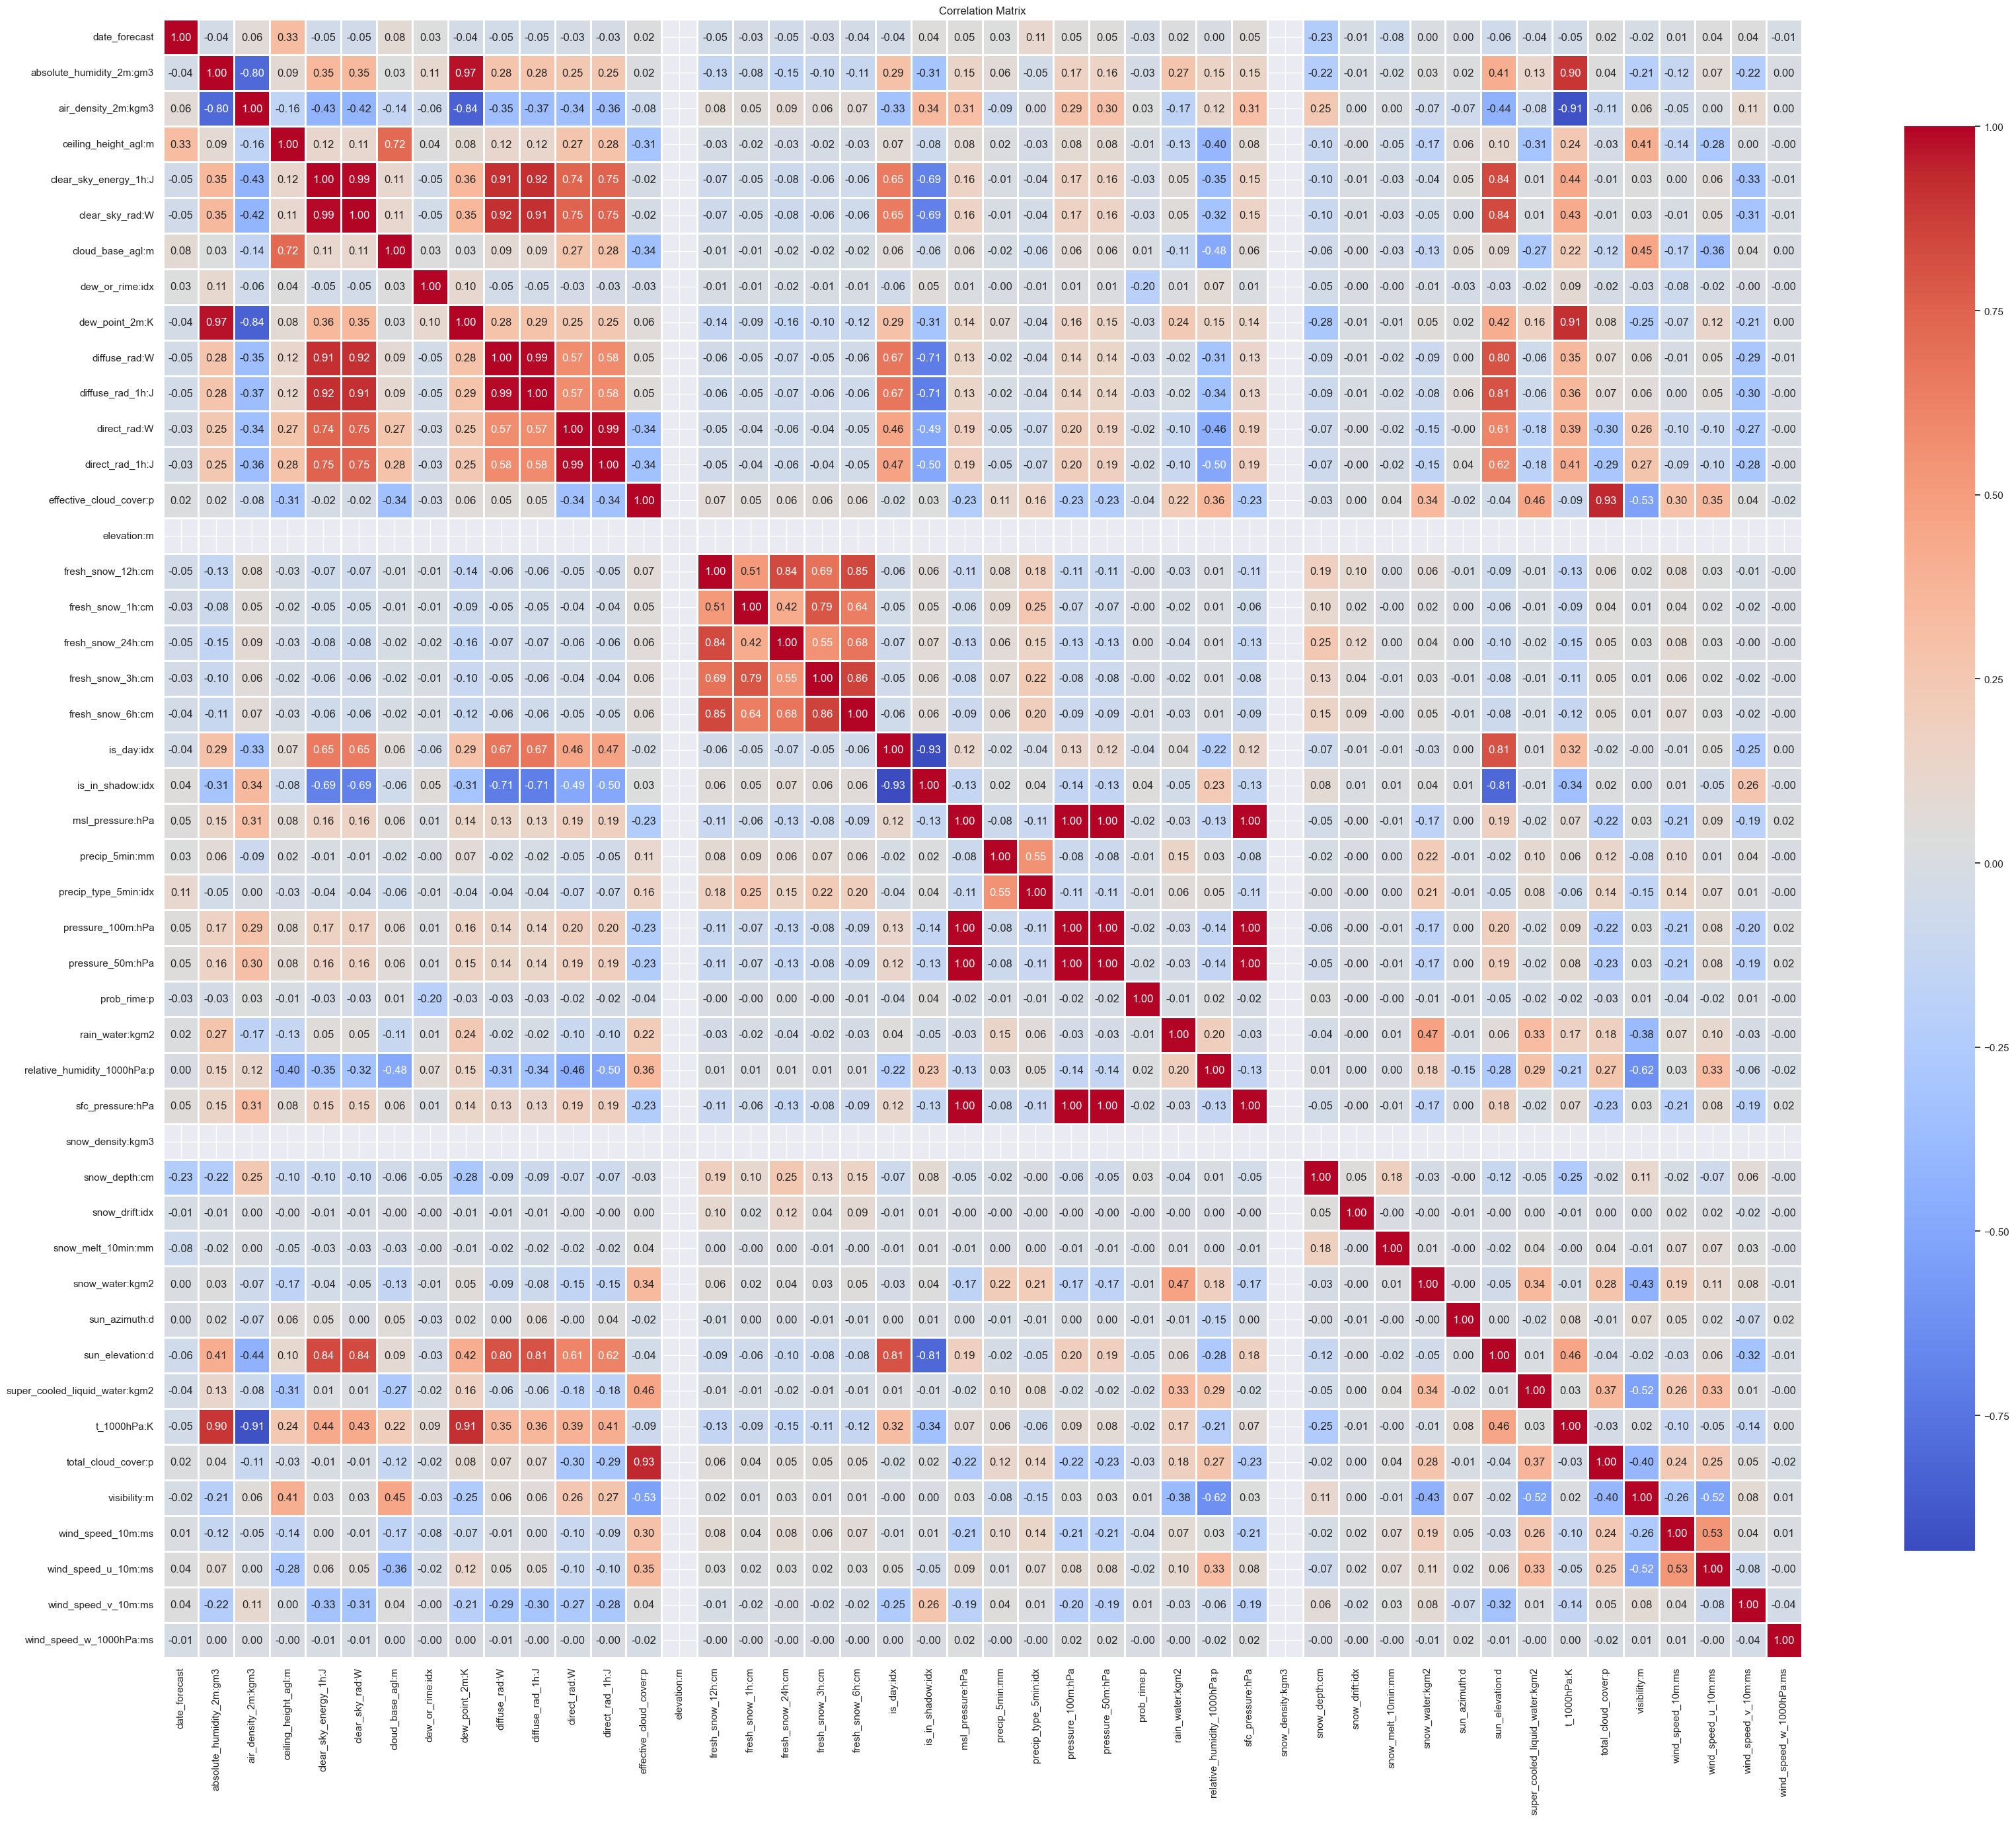

In [16]:
location = 'B'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


# The data to plot
df = X_train_observed   

# Exclude the first column (date forecast, it's the time axis)
columns_to_include = df.columns[:]

# Calculate the correlation matrix for selected columns
correlation_matrix = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

We will now focus on removing the highly correlated features. For that, we use the following function :

Removed elevation:m because it is NaN
Removed snow_density:kgm3 because it is NaN
Removed 	dew_point_2m:K	because it is correlated to	absolute_humidity_2m:gm3
Removed 	t_1000hPa:K	because it is correlated to	air_density_2m:kgm3
Removed 	clear_sky_rad:W	because it is correlated to	clear_sky_energy_1h:J
Removed 	diffuse_rad:W	because it is correlated to	clear_sky_energy_1h:J
Removed 	diffuse_rad_1h:J	because it is correlated to	clear_sky_energy_1h:J
Removed 	direct_rad_1h:J	because it is correlated to	direct_rad:W
Removed 	total_cloud_cover:p	because it is correlated to	effective_cloud_cover:p
Removed 	is_in_shadow:idx	because it is correlated to	is_day:idx
Removed 	pressure_100m:hPa	because it is correlated to	msl_pressure:hPa
Removed 	pressure_50m:hPa	because it is correlated to	msl_pressure:hPa
Removed 	sfc_pressure:hPa	because it is correlated to	msl_pressure:hPa
33 features remaining


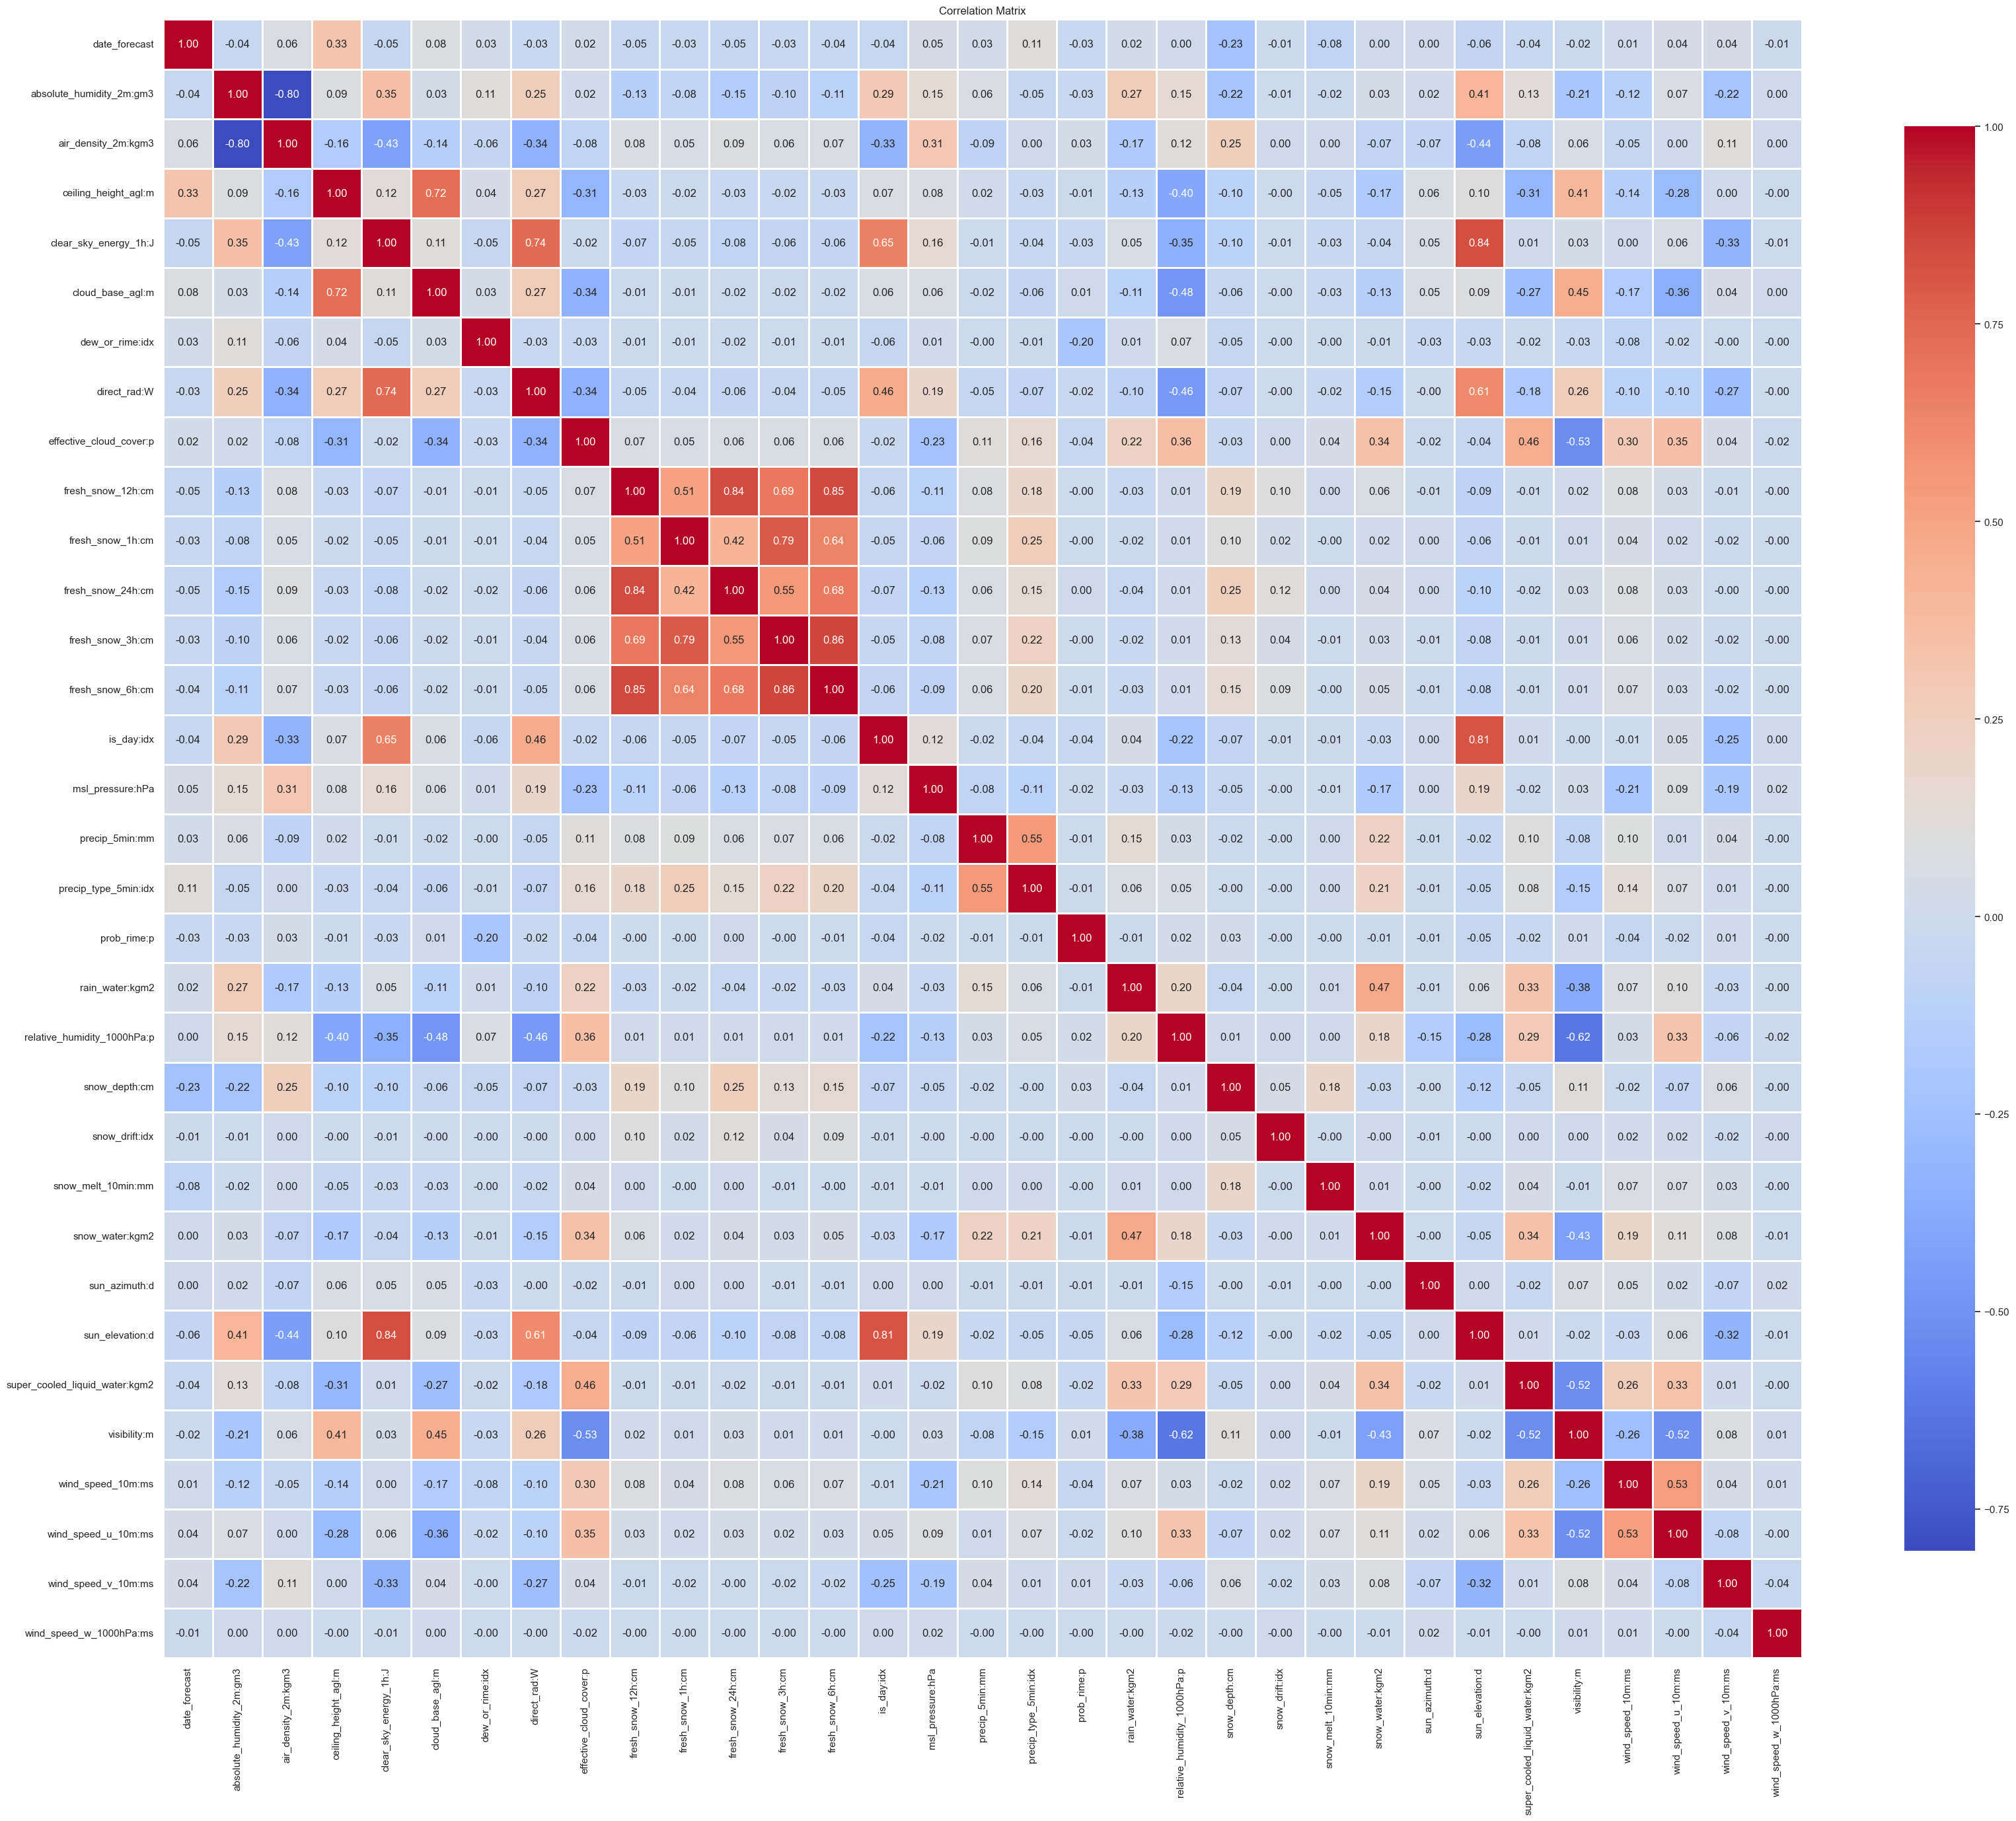

In [17]:
features = find_low_correlation_columns(X_train_observed,threshold=0.9)
print(f"{len(features)} features remaining")


# We now compute another correlation matrix to make sure that we excluded the correct features
# Select the non correlated features
columns_to_include = list(features)

# Calculate the correlation matrix for selected columns
correlation_matrix_filtered = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix_filtered,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

There are still `NaN` values in the data (both features and target data) that we need to replace.

In [7]:
location = 'C'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
index = 0
FEATURES = [] # Contains the list of useful features for each dataframe

threshold = 0.9

for dataframe in dataframes:
    print("** WORKING ON "+dataframe_names[index]+"**")
    features = find_low_correlation_columns(dataframe,threshold,verbose=False)
    FEATURES.append(features)
    for feature in features:
        fill_nan(dataframe,feature)
    index+=1

** WORKING ON train_target**
Missing data in pv_measurement  size  6060  out of 32155
Filled with bfill method
** WORKING ON X_train_observed**


C:\Users\NOE\AppData\Local\Temp\ipykernel_9336\633608867.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')
C:\Users\NOE\AppData\Local\Temp\ipykernel_9336\633608867.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='bfill')


Missing data in ceiling_height_agl:m  size  19923  out of 116825
Filled with ffill method
Missing data in cloud_base_agl:m  size  8512  out of 116825
Filled with ffill method
** WORKING ON X_train_estimated**
Missing data in ceiling_height_agl:m  size  4596  out of 17576
Filled with ffill method
Missing data in cloud_base_agl:m  size  2804  out of 17576
Filled with ffill method
** WORKING ON X_test_estimated**
Missing data in ceiling_height_agl:m  size  849  out of 2880
Filled with bfill method
Missing data in cloud_base_agl:m  size  375  out of 2880
Filled with ffill method


In [20]:
YData = train_target
XTrain = pd.concat([x_df])[FEATURES[1]]

# Make sure that the dates are in the correct order
YData.sort_values(by="time", inplace=True)
XTrain.sort_values(by="date_forecast", inplace=True)

# Now, we have to interpolate YData_selected to match the time interval of XData_selected
# First, ensure "time" column in YData_selected is in datetime format
YData['time'] = pd.to_datetime(YData['time'])
YData.set_index('time', inplace=True)
# Resample with a 15 minute time interval
YData_resampled = YData.resample('15T').interpolate(method='nearest') #  use 'linear' for better interpolation
YData_resampled = YData_resampled.reset_index()



# Extract the start and end dates from YData
start_date_Y = YData_resampled["time"].min()
end_date_Y = YData_resampled["time"].max()

# Extract the start and end dates from XData
start_date_X = XTrain["date_forecast"].min()
end_date_X = XTrain["date_forecast"].max()

# Only select dates where we have data for X and Y
start_date = max(start_date_Y,start_date_X)
end_date = min(end_date_Y,end_date_X)

# Select XData within the specified date range
XData_selected = XTrain[(XTrain["date_forecast"] >= start_date) & (XTrain["date_forecast"] <= end_date)]
YData_selected = YData_resampled[(YData_resampled["time"] >= start_date) & (YData_resampled["time"] <= end_date)]

XData_selected = XData_selected.drop(columns='date_forecast')
YData_selected = YData_selected['pv_measurement']

# Replace colons in the feature names
XData_selected.columns = [column.replace(":","_") for column in XData_selected.columns]

We can now train the light gbm model

In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [21]:
# Split dataset in train and test
X_train, X_test, Y_train, Y_test = train_test_split(XData_selected,YData_selected,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)


In [31]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 1000,
    "learning_rate": 0.05,
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=1000)

# Make Y_pred
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.0f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4182
[LightGBM] [Info] Number of data points in the train set: 94935, number of used features: 30
[LightGBM] [Info] Start training from score 674.676429
Mean Squared Error: 48957


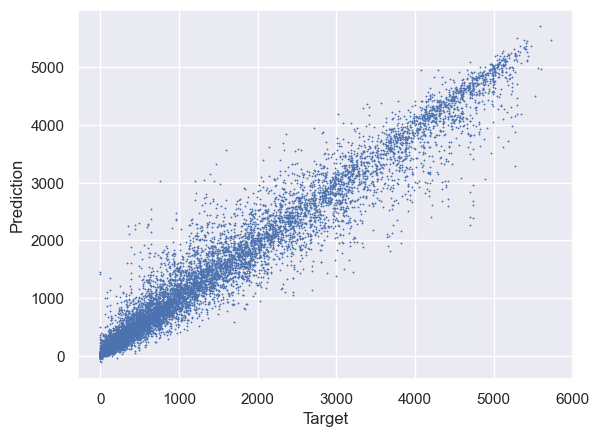

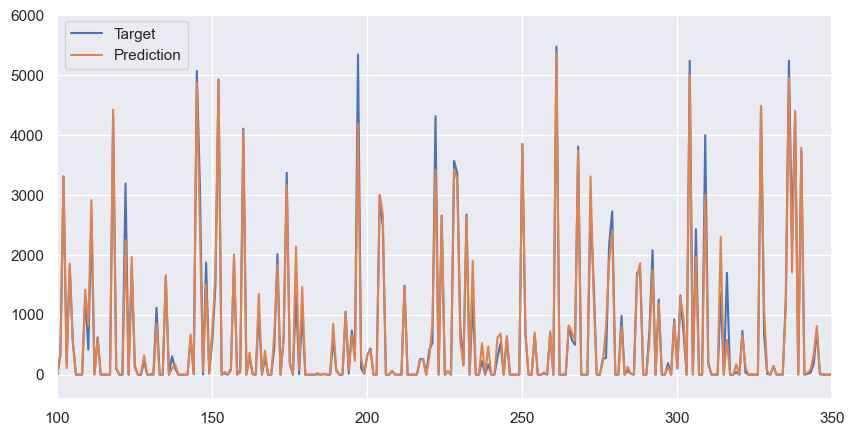

In [35]:
plt.figure()
plt.scatter(Y_test,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

This model is pretty dumb as there is no time awareness (using previous data), it is just regression on a vector. Also, we are only training using the observed data and not the forecasted one so it's not quite what we wanted. We will now use a sliding window

In [26]:
from sklearn.model_selection import TimeSeriesSplit

# Define your sliding window configuration
window_size = 4*1000  # The past 1000 hours
step_size = 4*500     # Move 500 hours forward

# Create TimeSeriesSplit with sliding window
tscv = TimeSeriesSplit(n_splits=(len(XData_selected) - window_size) // step_size + 1)

mse_scores = []

for train_index, test_index in tscv.split(XData_selected):
    # Extract the current window for training and testing
    train_indices = range(train_index[0], train_index[-1] + 1)
    test_indices = range(test_index[0], test_index[-1] + 1)

    X_train = XData_selected.iloc[train_indices]
    X_test = XData_selected.iloc[test_indices]
    Y_train = YData_selected.iloc[train_indices]
    Y_test = YData_selected.iloc[test_indices]

    # Convert data to LightGBM Dataset format
    train_data = lgb.Dataset(X_train, label=Y_train)
    test_data = lgb.Dataset(X_test, label=Y_test)

    # Set LightGBM hyperparameters
    params = {
        "objective": "regression",
        "metric": "mse",
        "num_leaves": 500,
        "learning_rate": 0.05,
    }

    # Train the LightGBM model
    model = lgb.train(params, train_data, num_boost_round=100)

    # Make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Evaluate the model
    mse = mean_squared_error(Y_test, y_pred)
    mse_scores.append(mse)

# Calculate the mean MSE across all sliding windows
mean_mse = sum(mse_scores) / len(mse_scores)
print(f"Mean Squared Error (across sliding windows): {mean_mse:.0f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 2031, number of used features: 22
[LightGBM] [Info] Start training from score 1153.849845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
y_pred = model.predict(XData_selected, num_iteration=model.best_iteration)

plt.figure()
plt.scatter(YData_selected,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

This is slower and has a higher MSE, not very good.

---
# Clean(?) data loader
Here we try to implement a cleaner version of the dataset loader. Eventually we would make this one single function

First, we read the data from the parquet files and get the low correlation columns as well as filling in the `NaN` values.

In [57]:
# Read dataframes
LOCATION = 'C'
train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(location = LOCATION)


# Process NaNs and highly correlated features
dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
index = 0
FEATURES = [] # Contains the list of useful features for each dataframe

threshold = 0.9

for dataframe in dataframes:
    print("** WORKING ON "+dataframe_names[index]+"**")
    # Replace colons with underscores in column names of 'dataframe'
    dataframe.columns = dataframe.columns.str.replace(':', '_')
    # Find low find_low_correlation_columns
    features = find_low_correlation_columns(dataframe,threshold,verbose=False)
    FEATURES.append(features)
    # Fill NaN
    for feature in dataframe.columns:
        fill_nan(dataframe,feature,verbose=False)
    index+=1

** WORKING ON train_target**
** WORKING ON X_train_observed**
** WORKING ON X_train_estimated**
** WORKING ON X_test_estimated**


Now we can process the datasets to select only time points where there is data in both the training and the target values.

In [58]:
Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)

X_Train,Y_Train = select_and_resample(Xdf,Ydf)

### Plots

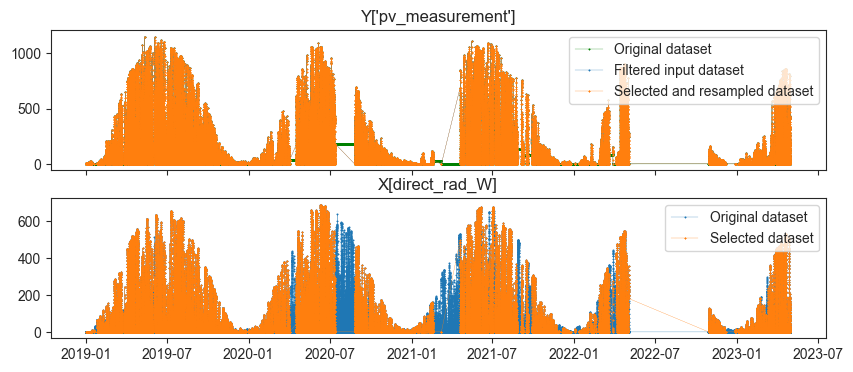

Before processing 
Y : (13408, 2)
X : (134505, 48)

After processing 
Y : (53596, 2)
X : (53596, 47)


In [6]:
# plot the difference between the original dataset and the filtered one
fig, axs = plt.subplots(figsize=(10,4), ncols=1, nrows=2, sharex=True)
axs[0].plot(train_target['time'],train_target['pv_measurement'],'-*g',linewidth = 0.2, markersize = 0.8, label = "Original dataset")
axs[0].plot(Ydf['time'],Ydf['pv_measurement'],'-*',linewidth = 0.2, markersize = 0.8, label="Filtered input dataset")
axs[0].plot(Y_Train['time'],Y_Train['pv_measurement'],'-x',linewidth = 0.2, markersize = 0.8, label = "Selected and resampled dataset")
axs[0].set_title("Y['pv_measurement']")
axs[0].legend()
axs[1].plot(Xdf['date_forecast'],Xdf['direct_rad_W'],'-*',linewidth = 0.2, markersize = 0.8, label = "Original dataset")
axs[1].plot(X_Train['date_forecast'],X_Train['direct_rad_W'],'-x',linewidth = 0.2, markersize = 0.8, label = "Selected dataset")
axs[1].set_title("X[direct_rad_W]")
axs[1].legend()

#plt.xlim([pd.Timestamp('2021-01-01'),pd.Timestamp('2021-02-01')])
plt.show()
fig.tight_layout()

print(f"Before processing \nY : {np.shape(Ydf)}\nX : {np.shape(Xdf)}\n")
print(f"After processing \nY : {np.shape(Y_Train)}\nX : {np.shape(X_Train)}")

It is now interesting to plot some statistics of the training target :

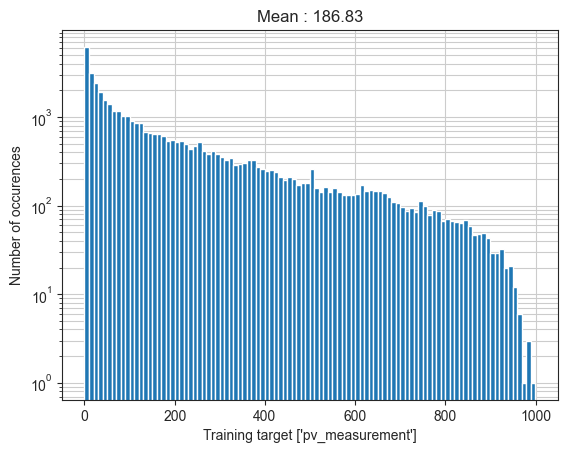

In [9]:
plt.figure()
plt.hist(Y_Train['pv_measurement'], bins=100)
plt.xlabel("Training target ['pv_measurement']")
plt.ylabel("Number of occurences")
plt.title(f"Mean : {Y_Train['pv_measurement'].mean():.2f}")
plt.yscale('log')
plt.grid(which='both')
plt.show()

There is a lot of 0

---

## Lagged features

The implementation above oversamples the target data to match the X data. The training is done as a simple regression from weather features (vector) at time $t$ to power output (scalar) at time $t$. We want to implement lagged features so that the prediction at time $t$ will use the features at times $\{t,t-15,t-30,t-45\}$

In [59]:
X_Train_lagged = lagged_features(X_Train)
X_test_lagged = lagged_features(X_test_estimated)

print(X_Train.shape)
print(X_Train_lagged.shape)

C:\Users\NOE\AppData\Local\Temp\ipykernel_12500\1351117424.py:386: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[column + suffix] = new_df[column].shift(periods=interval//15)
C:\Users\NOE\AppData\Local\Temp\ipykernel_12500\1351117424.py:386: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[column + suffix] = new_df[column].shift(periods=interval//15)
C:\Users\NOE\AppData\Local\Temp\ipykernel_12500\1351117424.py:386: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

(42360, 47)
(42360, 182)


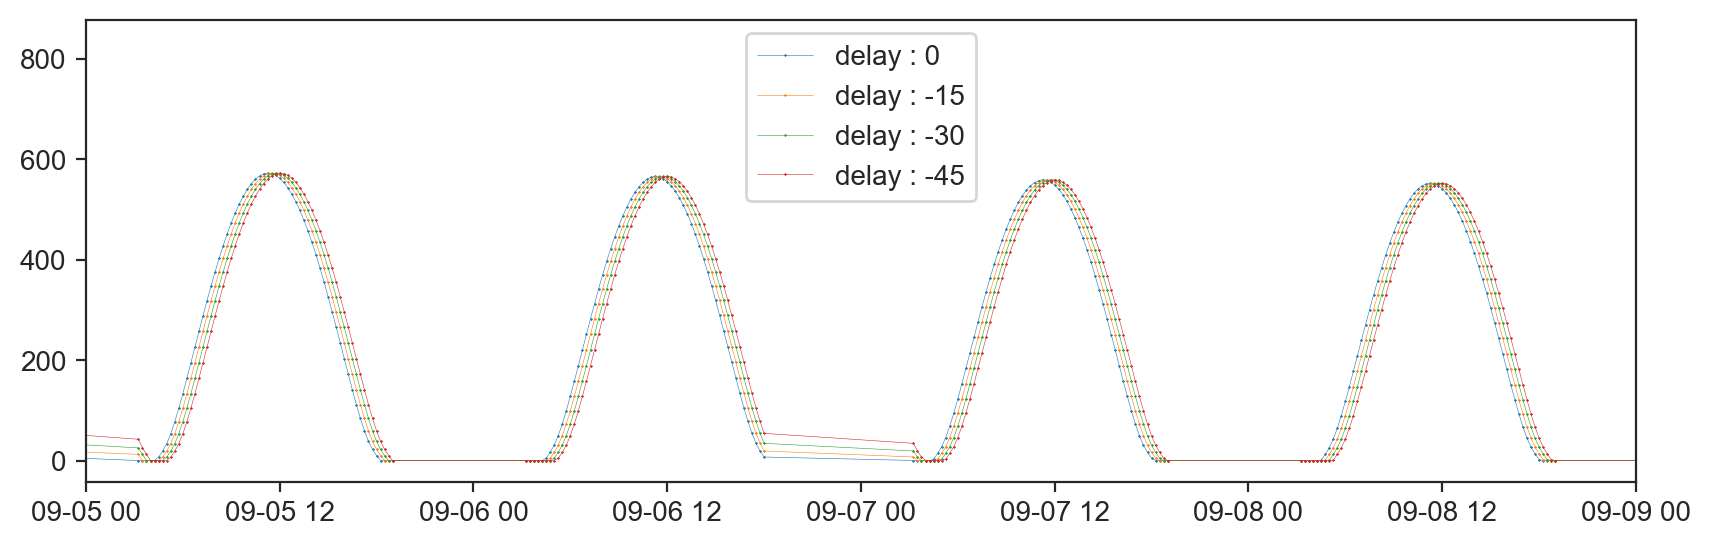

date_forecast  absolute_humidity_2m_gm3  air_density_2m_kgm3  \
1 2019-06-03 01:15:00                       8.4                1.218   
2 2019-06-03 01:30:00                       8.5                1.218   
3 2019-06-03 01:45:00                       8.6                1.218   
4 2019-06-03 02:00:00                       8.8                1.219   
5 2019-06-03 02:15:00                       8.9                1.218   

   ceiling_height_agl_m  clear_sky_energy_1h_J  clear_sky_rad_W  \
1           1318.400024               0.000000         0.000000   
2           1248.400024               0.000000         0.000000   
3           1178.500000             834.599976         3.000000   
4           1108.500000            6546.899902         9.800000   
5           1038.500000           18761.400391        17.299999   

   cloud_base_agl_m  dew_or_rime_idx  dew_point_2m_K  diffuse_rad_W  \
1       1318.400024              0.0      281.600006            0.0   
2       1248.400024              0.0      281.799988            0.0   
3       1178.500000              0.0      282.000000            1.2   
4       1108.500000              0.0      282.299988            4.3   
5       1038.500000              0.0      282.399994            8.5   

   diffuse_rad_1h_J  direct_rad_W  direct_rad_1h_J  effective_cloud_cover_p  \
1          0.000000           0.0              0.0               100.000000   
2          0.000000           0.0              0.0               100.000000   
3       2107.100098           0.0              0.0               100.000000   
4       7743.299805           0.0              0.0               100.000000   
5      15229.799805           0.0              0.0                90.099998   

   elevation_m  fresh_snow_12h_cm  fresh_snow_1h_cm  fresh_snow_24h_cm  \
1          6.0                0.0               0.0                0.0   
2          6.0                0.0               0.0                0.0   
3          6.0                0.0               0.0                0.0   
4          6.0                0.0               0.0                0.0   
5          6.0                0.0               0.0                0.0   

   fresh_snow_3h_cm  fresh_snow_6h_cm  is_day_idx  is_in_shadow_idx  \
1               0.0               0.0         0.0               1.0   
2               0.0               0.0         0.0               1.0   
3               0.0               0.0         1.0               1.0   
4               0.0               0.0         1.0               0.0   
5               0.0               0.0         1.0               0.0   

   msl_pressure_hPa  precip_5min_mm  precip_type_5min_idx  pressure_100m_hPa  \
1       1004.099976             0.0                   0.0         991.599976   
2       1003.900024             0.0                   0.0         991.400024   
3       1003.700012             0.0                   0.0         991.200012   
4       1003.400024             0.0                   0.0         990.900024   
5       1003.200012             0.0                   0.0         990.700012   

   pressure_50m_hPa  prob_rime_p  rain_water_kgm2  \
1        997.599976          0.0              0.1   
2        997.299988          0.0              0.1   
3        997.099976          0.0              0.1   
4        996.900024          0.0              0.1   
5        996.599976          0.0              0.1   

   relative_humidity_1000hPa_p  sfc_pressure_hPa  snow_density_kgm3  \
1                    73.000000       1003.599976                NaN   
2                    74.800003       1003.299988                NaN   
3                    76.599998       1003.099976                NaN   
4                    78.500000       1002.900024                NaN   
5                    79.400002       1002.599976                NaN   

   snow_depth_cm  snow_drift_idx  snow_melt_10min_mm  snow_water_kgm2  \
1            0.0             0.0                -0.0              0.6   
2            0.0         

In [8]:
featurename = 'clear_sky_rad_W'

plt.figure(dpi=200,figsize=(10,3))
plt.plot(X_Train_lagged['date_forecast'],X_Train_lagged[featurename],'-*',linewidth=0.2,markersize=0.2,label='delay : 0')
plt.plot(X_Train_lagged['date_forecast'],X_Train_lagged[featurename+'__r15'],'-*',linewidth=0.2,markersize=0.2,label='delay : -15')
plt.plot(X_Train_lagged['date_forecast'],X_Train_lagged[featurename+'__r30'],'-*',linewidth=0.2,markersize=0.2,label='delay : -30')
plt.plot(X_Train_lagged['date_forecast'],X_Train_lagged[featurename+'__r45'],'-*',linewidth=0.2,markersize=0.2,label='delay : -45')
plt.legend()
plt.xlim([pd.to_datetime('2019-09-05'), pd.to_datetime('2019-09-09')])
plt.show()

X_Train_lagged.head()

It is a bit trash because i could not find a way to fill the values that were not in the dataset with copy of the last known values so there are quite a few instances where the lagged features do not correspond to the data that was 15 minutes ago.


---
## Train models

There are no lagged features in the current datasets so these predictors will be simple dumb regression from a vector to a scalar without any time considerations. I am not doing any k-fold either because fuck good practices.

Also, there is absolutely zero consideration for statistics and normalization so the results can definitely be improved with better data processing

In [60]:
# Select the correct columns for the prediction
features_to_include = find_low_correlation_columns(X_Train,threshold=0.9,verbose=False)[1:-1] #remove the dates
features_to_include_lagged = [f+suffix for f in features_to_include[1:] for suffix in ['','__r15','__r30','__r45']]

# the lagged features code is a bit too extreme, a lot of unnecessary features so increased complexity for nothing

Y_train_selected = Y_Train['pv_measurement']
X_train_selected = normalize_dataframe(X_Train[features_to_include])
X_train_lagged_selected = normalize_dataframe(X_Train_lagged[features_to_include_lagged])
X_test_lagged_selected = normalize_dataframe(X_test_lagged[features_to_include_lagged])
RANDOM_SEED = 49

In [61]:
# Split training data into train, validation and test 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train_lagged_selected,Y_train_selected,
                                                    test_size=0.1,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True,
                                                    )
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,
                                               test_size=0.2,
                                               random_state=RANDOM_SEED,
                                               shuffle=False)

### LGB regression

In [15]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [16]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 1000,
    "learning_rate": 0.05,
    "num_threads" : 2,
}

# Train the LightGBM model
lgb_model = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3794
[LightGBM] [Info] Number of data points in the train set: 33888, number of used features: 32
[LightGBM] [Info] Start training from score 187.665394


In [17]:
# Make predictions
Y_pred = np.asarray(lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration))

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.0f}")

Mean Squared Error: 867


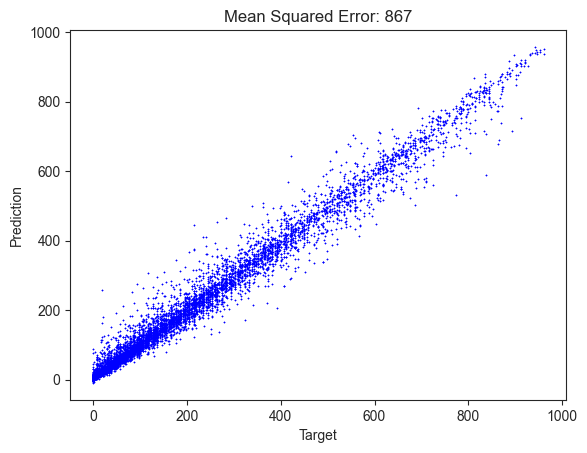

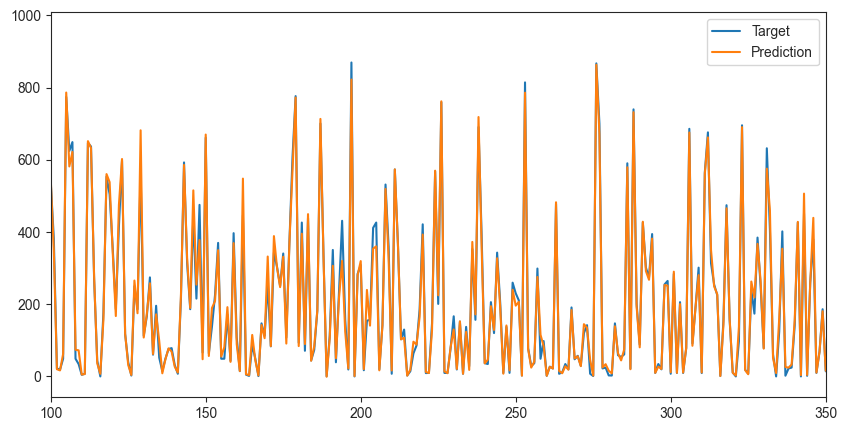

In [18]:
plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Mean Squared Error: {mse:.0f}")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,Y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

### CatBoost regression

In [11]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

In [12]:
from catboost.utils import get_gpu_device_count
print('Detected GPU devices : %i' % get_gpu_device_count())

Detected GPU devices : 1


Train the model

In [20]:
catboost_model = CatBoostRegressor(iterations=5000,
                          depth=13,
                          learning_rate=0.25,
                          l2_leaf_reg=7,
                          loss_function='RMSE',
                          task_type='GPU',
                          devices='0',
                          verbose=100)

catboost_model.fit(X_train, Y_train)

0:	learn: 1094.4341605	total: 358ms	remaining: 23m 49s
100:	learn: 208.0849141	total: 17.5s	remaining: 11m 16s
200:	learn: 125.8115003	total: 34.2s	remaining: 10m 46s
300:	learn: 87.4294334	total: 51s	remaining: 10m 27s
400:	learn: 67.1929540	total: 1m 7s	remaining: 10m 7s
500:	learn: 54.3600414	total: 1m 24s	remaining: 9m 48s
600:	learn: 45.3073522	total: 1m 40s	remaining: 9m 30s
700:	learn: 38.7829380	total: 1m 57s	remaining: 9m 12s
800:	learn: 33.5470608	total: 2m 13s	remaining: 8m 54s
900:	learn: 29.3624841	total: 2m 30s	remaining: 8m 37s
1000:	learn: 26.0727960	total: 2m 47s	remaining: 8m 20s
1100:	learn: 23.1258093	total: 3m 3s	remaining: 8m 3s
1200:	learn: 20.7529425	total: 3m 20s	remaining: 7m 46s
1300:	learn: 18.5851757	total: 3m 36s	remaining: 7m 29s
1400:	learn: 16.7413006	total: 3m 53s	remaining: 7m 13s
1500:	learn: 15.1231302	total: 4m 11s	remaining: 6m 58s
1600:	learn: 13.6837030	total: 4m 28s	remaining: 6m 42s
1700:	learn: 12.4451093	total: 4m 45s	remaining: 6m 25s
1800:

Test the model

MAE = 107


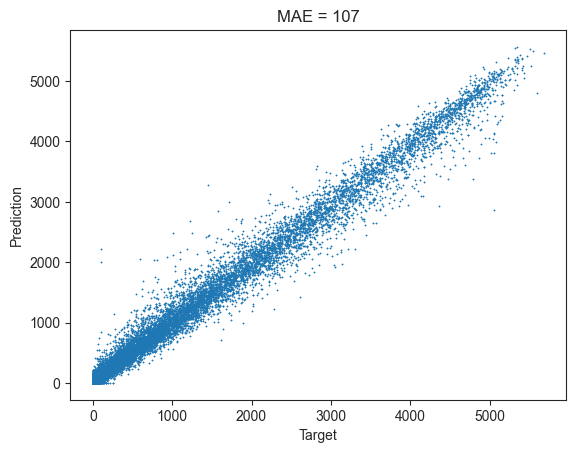

In [21]:
# Make predictions every 15 minutes
Y_pred = catboost_model.predict(X_test)
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)
#mse_hour = mean_squared_error(Y_test_hour['pv_measurement'], Y_pred_hour['pv_measurement'])


print(f"MAE = {mae:.0f}")
#print(f"MSE (round hours)= {mse_hour:.0f}")


plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*",)
#plt.scatter(Y_test_hour['pv_measurement'],Y_pred_hour['pv_measurement'],s=0.05,c="r",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"MAE = {mae:.0f}")
plt.show()

In [22]:
feature_importance = catboost_model.get_feature_importance(prettified=True)
print(feature_importance)

                              Feature Id   Importances
0                           direct_rad_W  1.160369e+01
1                        sun_elevation_d  8.971274e+00
2                     sun_azimuth_d__r45  3.921815e+00
3                     sun_azimuth_d__r30  3.642701e+00
4                     sun_azimuth_d__r15  3.465989e+00
5                effective_cloud_cover_p  2.518904e+00
6                       msl_pressure_hPa  2.492664e+00
7                  msl_pressure_hPa__r30  2.095678e+00
8          absolute_humidity_2m_gm3__r15  1.993612e+00
9               absolute_humidity_2m_gm3  1.946715e+00
10                 msl_pressure_hPa__r45  1.910697e+00
11                     direct_rad_W__r15  1.890170e+00
12              wind_speed_u_10m_ms__r15  1.867202e+00
13              wind_speed_v_10m_ms__r30  1.828769e+00
14                     direct_rad_W__r30  1.796383e+00
15                 msl_pressure_hPa__r15  1.658470e+00
16         absolute_humidity_2m_gm3__r45  1.652874e+00
17        

Using a randomized search for the hyper parameters of the catboost regressor.

**WARNING : this is very long (~60+ minutes)** 

In [34]:
model = CatBoostRegressor()

grid = {'learning_rate': [0.20,0.25,0.30,0.35,0.40,0.45],
        'depth': [7,9,10,11,12,13],
        'l2_leaf_reg': [5, 7, 8, 9, 11]}

randomized_search_result = model.randomized_search(grid,
                                                   X=X_train,
                                                   y=Y_train,
                                                   plot=True,
                                                   verbose=False,
                                                   n_iter=20)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 210.7726040	test: 211.2018088	best: 211.2018088 (0)	total: 21.5ms	remaining: 21.4s
1:	learn: 162.4359077	test: 162.1967344	best: 162.1967344 (1)	total: 36.2ms	remaining: 18.1s
2:	learn: 131.3212921	test: 130.6754543	best: 130.6754543 (2)	total: 52.9ms	remaining: 17.6s
3:	learn: 110.5865131	test: 109.8567849	best: 109.8567849 (3)	total: 73ms	remaining: 18.2s
4:	learn: 98.7744919	test: 97.7076064	best: 97.7076064 (4)	total: 90.4ms	remaining: 18s
5:	learn: 90.4056752	test: 89.4279764	best: 89.4279764 (5)	total: 105ms	remaining: 17.5s
6:	learn: 85.6025612	test: 84.5766783	best: 84.5766783 (6)	total: 120ms	remaining: 17s
7:	learn: 82.6743153	test: 81.7199902	best: 81.7199902 (7)	total: 132ms	remaining: 16.3s
8:	learn: 80.9716349	test: 79.9530428	best: 79.9530428 (8)	total: 143ms	remaining: 15.7s
9:	learn: 79.5931570	test: 78.7067816	best: 78.7067816 (9)	total: 165ms	remaining: 16.4s
10:	learn: 78.2844737	test: 77.6487725	best: 77.6487725 (10)	total: 181ms	remaining: 16.3s
11:	lear

In [17]:
# save model A

# training data :
"""
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=12,
                          learning_rate=0.3,
                          l2_leaf_reg=7,
                          loss_function='RMSE',
                          verbose=100)
"""

catboostA = catboost_model
catboostA.save_model('CatBoostA_test.cbm',format='cbm')

In [29]:
# save model B

# training data :
"""
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=11,
                          learning_rate=0.25,
                          l2_leaf_reg=7,
                          loss_function='RMSE',
                          verbose=100)
"""

catboostB = catboost_model
catboostB.save_model('CatBoostB_test.cbm',format='cbm')

In [38]:
# save model C

# training data :
"""
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=12,
                          learning_rate=0.20,
                          l2_leaf_reg=11,
                          loss_function='RMSE',
                          verbose=100)
"""

catboostC = catboost_model
catboostC.save_model('CatBoostC_test.cbm',format='cbm')

We can try to train again using only the top 20 feature for example and see if it leads to better results

I did it and it was not convincing.

### MLP regression

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from sklearn.metrics import mean_absolute_error

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # set to 0 to use GPU

In [11]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # If GPUs are available, allow memory growth and select a GPU device
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
else:
    print("No GPU devices found. Using CPU.")

No GPU devices found. Using CPU.


In [62]:
# Convert pandas dataframes to numpy arrays
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()
X_val = X_val.to_numpy()
Y_val = Y_val.to_numpy()

# Check for NaN values
print(np.isnan(X_train).any())
print(np.isnan(Y_train).any())
print(np.isnan(X_val).any())
print(np.isnan(Y_val).any())

False
False
False
False


In [63]:
# Define hyperparameters and model architecture
input_shape = X_train.shape[1]  # Shape of input data (number of features)
output_shape = 1                # Shape of output data (scalar)

In [64]:
# Define model architecure
model = Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Dense(input_shape, activation='linear'))  # Input layer
model.add(Dense(256, activation='relu'))            # Hidden layer
model.add(Dense(512, activation='relu'))            # Hidden layer
model.add(Dense(256, activation='relu'))            # Hidden layer
model.add(Dense(128, activation='relu'))            # Hidden layer
model.add(Dense(64, activation='relu'))             # Hidden layer
model.add(Dense(32, activation='relu'))             # Hidden layer
model.add(Dense(output_shape, activation='linear')) # Output layer

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 124)               15500     
                                                                 
 dense_17 (Dense)            (None, 256)               32000     
                                                                 
 dense_18 (Dense)            (None, 512)               131584    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)               

In [49]:
# Training parameters
num_epochs = 300  
batch_size = 256  

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics = 'MeanAbsoluteError')

# Train the model
history = model.fit(X_train, Y_train, 
          epochs=num_epochs, 
          batch_size=batch_size,
          validation_data=(X_val,Y_val),
          verbose=2)

Epoch 1/300
151/151 - 3s - loss: 27701.1211 - mean_absolute_error: 102.7133 - val_loss: 9783.9238 - val_mean_absolute_error: 62.0614 - 3s/epoch - 18ms/step
Epoch 2/300
151/151 - 2s - loss: 9687.8867 - mean_absolute_error: 61.3572 - val_loss: 9126.8311 - val_mean_absolute_error: 58.1233 - 2s/epoch - 13ms/step
Epoch 3/300
151/151 - 2s - loss: 9531.8369 - mean_absolute_error: 60.5346 - val_loss: 8953.4678 - val_mean_absolute_error: 59.5713 - 2s/epoch - 11ms/step
Epoch 4/300
151/151 - 2s - loss: 9124.9072 - mean_absolute_error: 59.0435 - val_loss: 9452.0078 - val_mean_absolute_error: 59.5976 - 2s/epoch - 13ms/step
Epoch 5/300
151/151 - 2s - loss: 8763.6133 - mean_absolute_error: 57.2455 - val_loss: 8672.2559 - val_mean_absolute_error: 55.7440 - 2s/epoch - 12ms/step
Epoch 6/300
151/151 - 2s - loss: 8506.1992 - mean_absolute_error: 56.1856 - val_loss: 8052.1060 - val_mean_absolute_error: 54.1018 - 2s/epoch - 12ms/step
Epoch 7/300
151/151 - 2s - loss: 8122.4521 - mean_absolute_error: 54.5843 

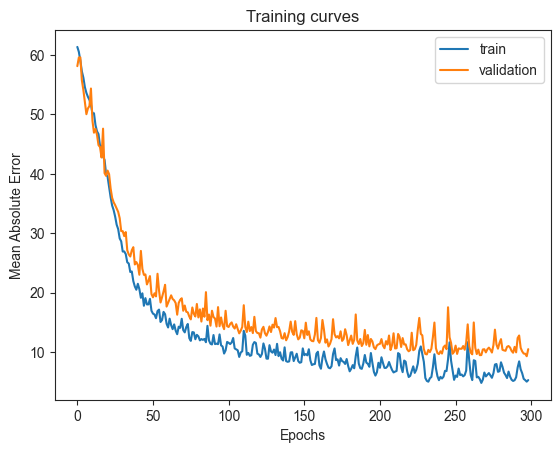

In [50]:
# plot history
plt.title("Training curves")
plt.plot(history.history['mean_absolute_error'][1:], label='train')
plt.plot(history.history['val_mean_absolute_error'][1:], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

168/168 [==============================] - 1s 4ms/step
MAE = 11


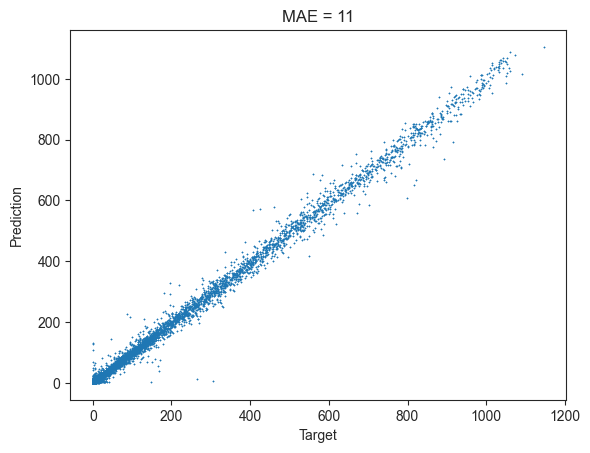

In [51]:
# Make predictions every 15 minutes
Y_pred = model.predict(X_test.to_numpy())
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)

print(f"MAE = {mae:.0f}")


plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"MAE = {mae:.0f}")
plt.show()

In [52]:
# Save model

path = "./MLP_models/"+LOCATION+"_v2/"
model.save(path)

INFO:tensorflow:Assets written to: ./MLP_models/B_v2/assets


In [12]:
# Load model

path = "./MLP_models/"+LOCATION+"/"
MLP_model = tf.keras.models.load_model(path)

### LSTM

In [30]:
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [31]:
# convert series to supervised learning
def series_to_supervised(data,Name_features, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s %d(t-%d)' % (Name_features[j],j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s %d(t)' % (Name_features[j],j+1)) for j in range(n_vars)]
        else:
            names += [('%s %d(t+%d)' % (Name_features[j],j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg



# Define a function to create and train an LSTM model
def create_lstm_model(input_shape, nbr_unit):
    model = Sequential()
    model.add(LSTM(units= nbr_unit, activation='relu', input_shape=input_shape,
            kernel_regularizer=l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)
                ))
    #model.add(Dropout(0.2))
    model.add(Dense(1, kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01)))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics='MeanAbsoluteError')
    return model



# Define a function to create input and output sequences for the LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [45]:
#Transform panda into dataset with lag

#Add y data at the end
Dataframe = X_train_lagged_selected#.drop(columns=['date_forecast'])
Name_features = Dataframe.columns

values = Dataframe.values
values = values.astype('float32')

n_in = 4    # Number of lag observations as input
n_out = 1   #Number of observations as output (y)

# frame as supervised learning
reframed = series_to_supervised(values,Name_features, n_in, n_out)

#Add pv_measurement at the end as target
#reframed = pd.concat((reframed,Y_Train_obs.reset_index().iloc[:,2]), axis=1)

nan_features = [var for var in reframed.columns if reframed[var].isnull().sum() > 0]

for features in nan_features:
    fill_nan(reframed, features,verbose=False)
    #print("\n")
    
#Save dataframe before normalization for reference
#reference_dataset = pd.concat([X_train_selected['date_forecast'].reset_index(),reframed.copy()], axis=1, ignore_index=True)
#reference_dataset = reference_dataset.drop(reference_dataset.columns[0], axis=1)
#reference_dataset.columns= reframed.columns.insert(0,'date_forecast')

#Normalization
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = pd.DataFrame(scaled, columns=reframed.columns)

In [46]:
#Get data into proper shape for LSTM

#Split train/test
values = reframed.values
split = int(reframed.shape[0]*0.8)
train_X = values[:split, :]
test_X = values[split:, :]

train_y = Y_Train.reset_index().iloc[:,2].values[:split]
test_y = Y_Train.reset_index().iloc[:,2].values[split:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(42876, 1, 620) (42876,) (10720, 1, 620) (10720,)


In [47]:
#Simple training for the moment without timeseriesplit
model = create_lstm_model(input_shape=(train_X.shape[1],train_X.shape[2]), nbr_unit=50)
history = model.fit(train_X,
                    train_y,
                    epochs=100,
                    batch_size=128,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)

Epoch 1/100
335/335 - 4s - loss: 80018.0703 - mean_absolute_error: 187.1576 - val_loss: 23912.0977 - val_mean_absolute_error: 98.0596 - 4s/epoch - 12ms/step
Epoch 2/100
335/335 - 2s - loss: 26596.6250 - mean_absolute_error: 106.2001 - val_loss: 10352.9443 - val_mean_absolute_error: 67.0901 - 2s/epoch - 6ms/step
Epoch 3/100
335/335 - 2s - loss: 14779.1768 - mean_absolute_error: 79.0324 - val_loss: 8906.2227 - val_mean_absolute_error: 60.7997 - 2s/epoch - 6ms/step
Epoch 4/100
335/335 - 2s - loss: 12857.5303 - mean_absolute_error: 73.1093 - val_loss: 8746.1133 - val_mean_absolute_error: 59.2433 - 2s/epoch - 6ms/step
Epoch 5/100
335/335 - 2s - loss: 12274.5625 - mean_absolute_error: 71.2671 - val_loss: 8320.0225 - val_mean_absolute_error: 56.4078 - 2s/epoch - 7ms/step
Epoch 6/100
335/335 - 2s - loss: 12044.2393 - mean_absolute_error: 70.3092 - val_loss: 8297.7012 - val_mean_absolute_error: 55.6196 - 2s/epoch - 7ms/step
Epoch 7/100
335/335 - 2s - loss: 11952.4102 - mean_absolute_error: 69.7

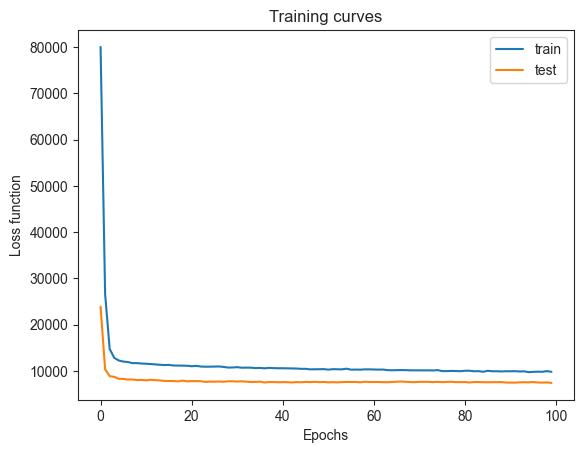

In [50]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

335/335 [==============================] - 1s 3ms/step
MAE = 48


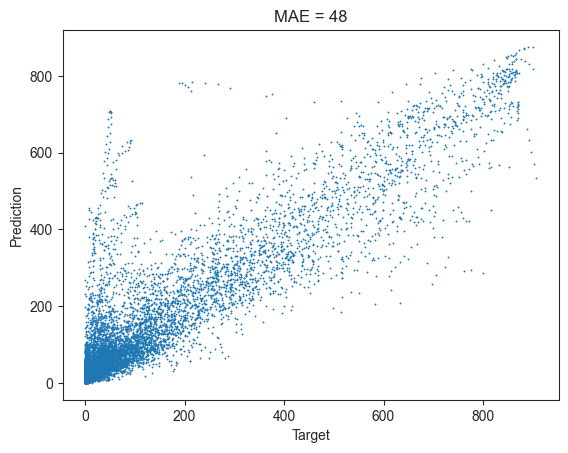

In [51]:
# Make predictions every 15 minutes
Y_pred = model.predict(test_X)
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(test_y, Y_pred)

print(f"MAE = {mae:.0f}")


plt.figure()
plt.scatter(test_y,Y_pred,s=0.05,marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"MAE = {mae:.0f}")
plt.show()

---
## Tests

In [16]:
# Prediction on the whole training dataset (dumb)
Y = MLP_model.predict(X_train_lagged_selected)
Y[Y<0]=0

mae = mean_absolute_error(Y, Y_train_selected)

2433/2433 [==============================] - 6s 3ms/step


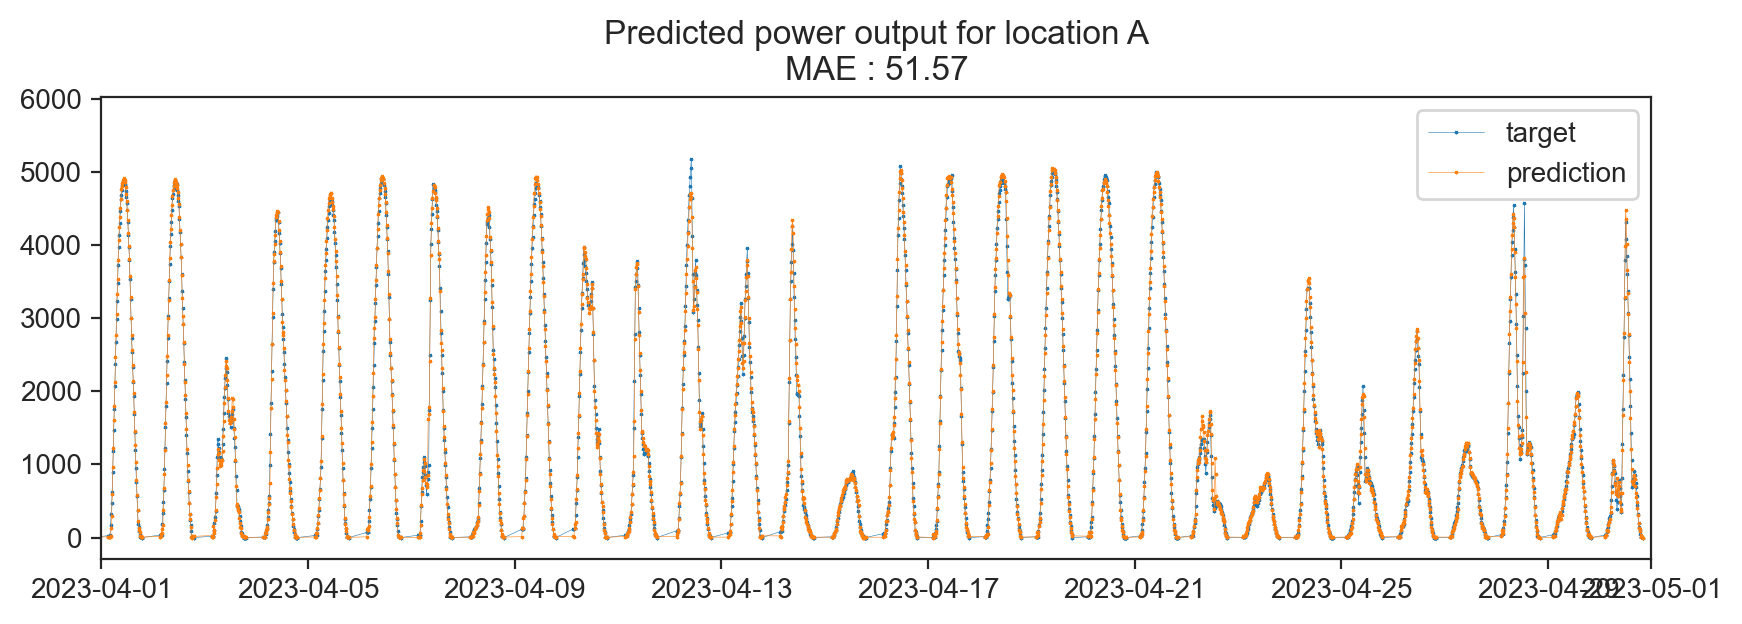

In [24]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(X_Train['date_forecast'],Y_train_selected,'-*',linewidth = 0.2, markersize = 0.8, label = 'target')
plt.plot(X_Train['date_forecast'],Y, '-*', linewidth = 0.2, markersize = 0.8, label = 'prediction')
plt.title(f"Predicted power output for location {LOCATION}\nMAE : {mae:.2f}")
plt.legend()
plt.xlim([pd.to_datetime('2023-04-01'),pd.to_datetime('2023-05-01')])
plt.show()

## Make a prediction for Kaggle

### Catboost

In [54]:
catboost_model = CatBoostRegressor()
catboost_model.load_model("CatBoost_models/CatBoost"+LOCATION+"_test.cbm",format='cbm')

In [55]:
# Predict on the X_test_estimated dataset
X_Test = normalize_dataframe(X_test_lagged[features_to_include_lagged])

Y_test_estimated = pd.DataFrame()
pv_measurement =  catboost_model.predict(X_test_estimated[FEATURES[1][1:]])
pv_measurement[pv_measurement<0]=0
Y_test_estimated['prediction'] = pv_measurement

Y_test_estimated['time'] = X_test_estimated['date_forecast']
Y_test_estimated_round = select_o_clock(Y_test_estimated,'time')
Y_test_estimated_round['location'] = LOCATION

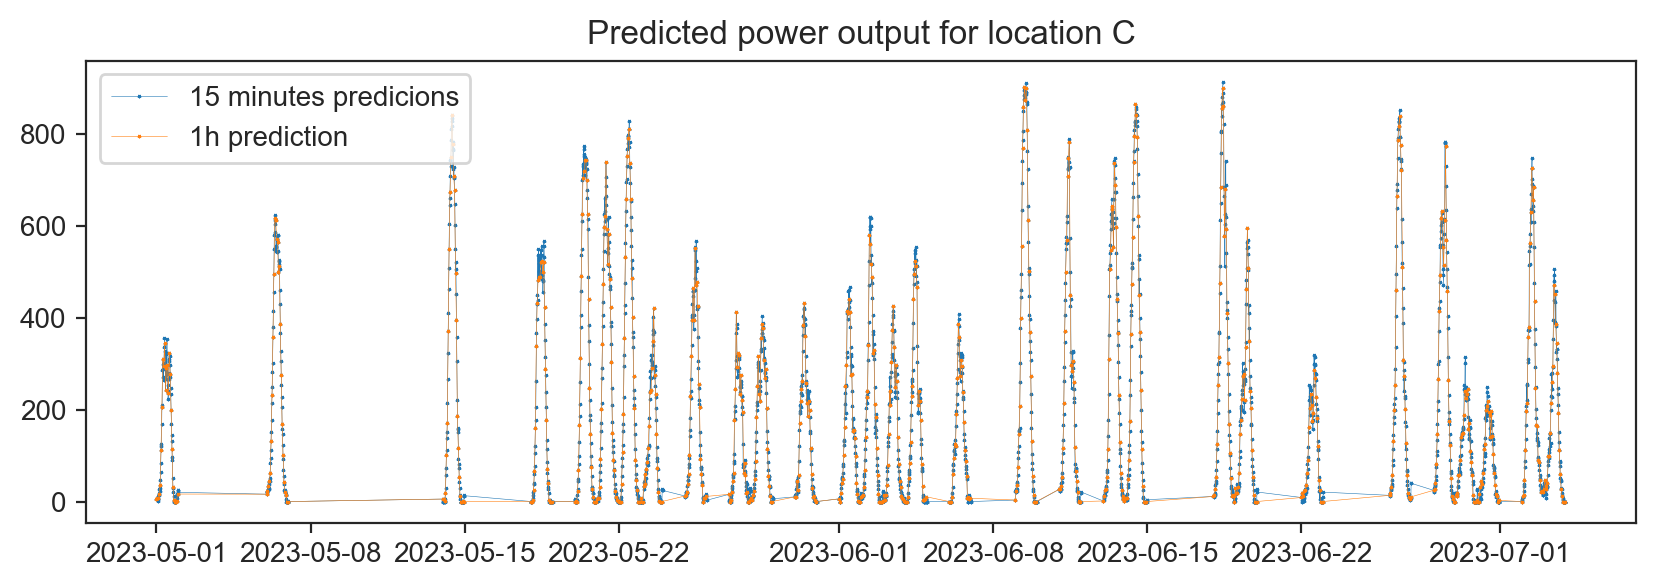

In [56]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(Y_test_estimated['time'],Y_test_estimated['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="15 minutes predicions")
plt.plot(Y_test_estimated_round['time'],Y_test_estimated_round['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="1h prediction")
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()
#plt.xlim([pd.to_datetime('2023-05-01'),pd.to_datetime('2023-05-02')])
plt.show()

In [52]:
# ONLY RUN FOR LOCATION A
PREDICTION_A = Y_test_estimated_round['prediction']

In [47]:
# ONLY RUN FOR LOCATION B
PREDICTION_B = Y_test_estimated_round['prediction']

In [57]:
# ONLY RUN FOR LOCATION C
PREDICTION_C = Y_test_estimated_round['prediction']

In [62]:
# Concatenate all 3 predictions
submission = pd.concat([PREDICTION_A, PREDICTION_B, PREDICTION_C]).reset_index()
# Add id colum 
submission['id'] = submission.index
submission

index  prediction    id
0         0    0.000000     0
1         4    0.000000     1
2         8   16.271863     2
3        12    0.000000     3
4        16  179.800333     4
...     ...         ...   ...
2155   2860   28.300571  2155
2156   2864   13.016177  2156
2157   2868    0.000000  2157
2158   2872    0.000000  2158
2159   2876    0.000000  2159

[2160 rows x 3 columns]

In [63]:
# SAVE TO CSV 
name = "new_submission"
submission.to_csv("Submissions/"+name+".csv",
                  columns=['id','prediction'],
                  index=False,
                  encoding='utf8')

### MLP

In [53]:
# Load model

path = "./MLP_models/"+LOCATION+"_v2/"
MLP_model = tf.keras.models.load_model(path)

In [54]:
# Make prediction
X_test_lagged_np = X_test_lagged_selected.to_numpy()

# Make predictions
prediction=pd.DataFrame()
pv_measurement =  MLP_model.predict(X_test_lagged_np).flatten()
pv_measurement[pv_measurement<0]=0
prediction['prediction'] = pv_measurement

# select round hours predictions
prediction['time'] = X_test_estimated['date_forecast']
prediction_round = select_o_clock(prediction,'time')

90/90 [==============================] - 1s 5ms/step


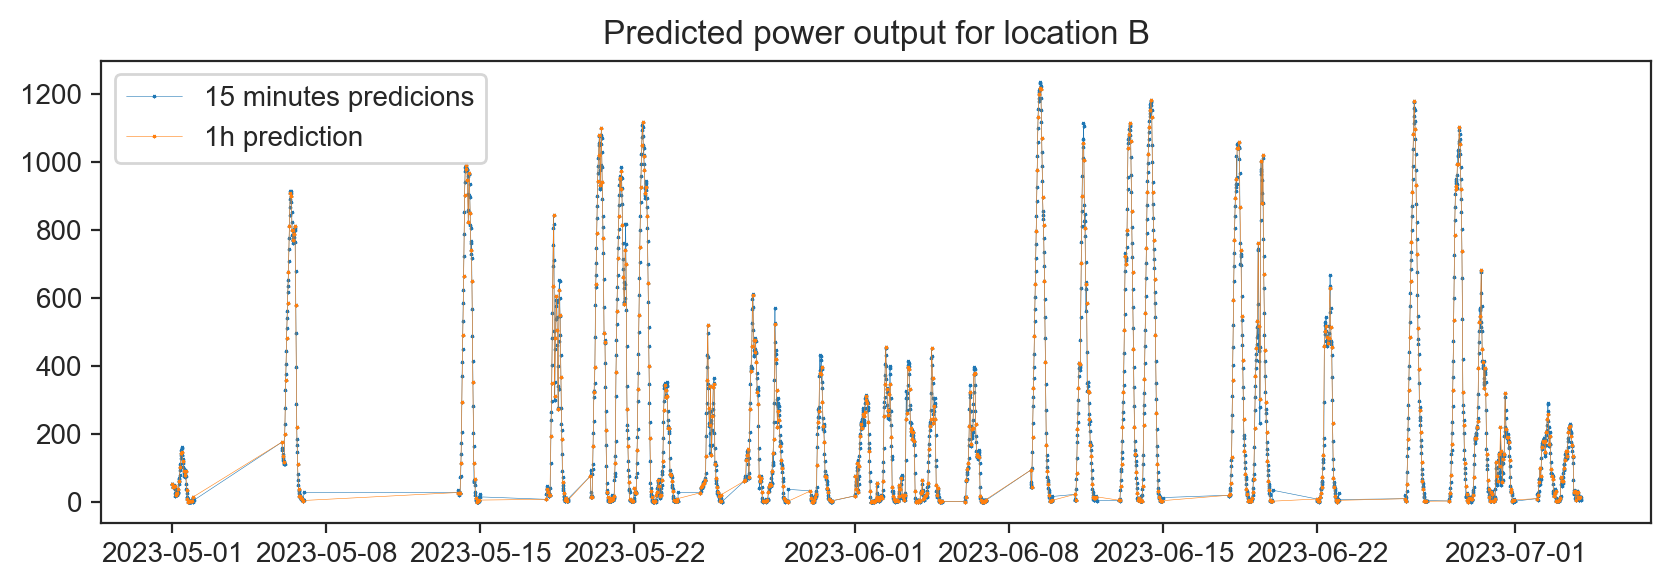

In [55]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(prediction['time'],prediction['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="15 minutes predicions")
plt.plot(prediction_round['time'],prediction_round['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="1h prediction")
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()
#plt.xlim([pd.to_datetime('2023-05-01'),pd.to_datetime('2023-05-02')])
plt.show()

In [40]:
# ONLY RUN FOR LOCATION A
PREDICTION_A = prediction_round['prediction']

In [56]:
# ONLY RUN FOR LOCATION B
PREDICTION_B = prediction_round['prediction']

In [69]:
# ONLY RUN FOR LOCATION C
PREDICTION_C = prediction_round['prediction']

In [70]:
# Concatenate all 3 predictions
submission = pd.concat([PREDICTION_A, PREDICTION_B, PREDICTION_C]).reset_index()
# Add id colum 
submission['id'] = submission.index
submission

index  prediction    id
0         0  624.772705     0
1         4  596.928406     1
2         8  611.782043     2
3        12  660.751038     3
4        16  813.219299     4
...     ...         ...   ...
2155   2860   39.449898  2155
2156   2864   17.374371  2156
2157   2868    1.011705  2157
2158   2872    0.245419  2158
2159   2876    1.572223  2159

[2160 rows x 3 columns]

In [71]:
# SAVE TO CSV 
name = "submission_MLP_check"
submission.to_csv("Submissions/"+name+".csv",
                  columns=['id','prediction'],
                  index=False,
                  encoding='utf8')

### Compare

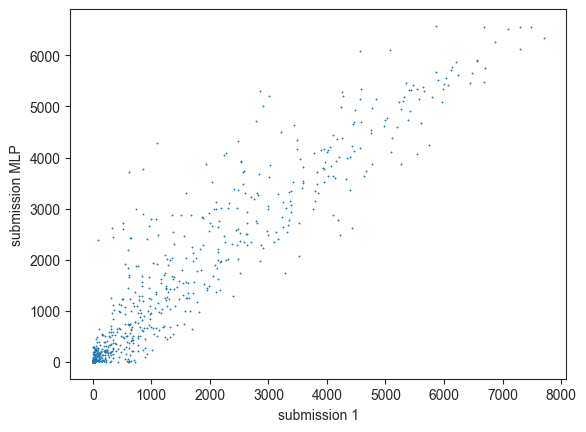

In [30]:
# Compare with previous solutions
sub1 = pd.read_csv('Submissions/submission_MLP.csv')
sub2 = pd.read_csv('Submissions/submission_MLP_check.csv')

plt.figure()
plt.scatter(sub1['prediction'],sub2['prediction'],s=0.05,marker="*")
plt.xlabel("submission 1")
plt.ylabel("submission MLP")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

plt.figure(figsize=(10,3),dpi=200)
plt.plot(sub1['id'],sub1['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label = 'Submission 1')
plt.plot(sub2['id'],sub2['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label = 'Submission 2')
plt.xlabel("id")
plt.ylabel("prediction")
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.show()
